# Classificador de contas contábeis
O objetivo deste projeto é criar um classificador de contas contábeis para ajudar a identificar e categorizar lançamentos financeiros de uma empresa. Nessa primeira etapa, vamos explorar e analisar os dados para entender melhor o problema e identificar as características relevantes para o classificador.

## Quais serão os próximos passos?
- Aumentar a probabilidade de acerto para acima de 70%
- Preencher a conta contábil quando estiver vazia e a probabilidade for maior de 70%. Caso contrário, dê uma sugestão da conta a ser preenchida na coluna "Probabilidade".
- Criar um relatório de classificação com a matriz de confusão
- Preencher a conta contábil e a probabilidade, gerando uma nova planilha com os resultados

## Bibliotecas utilizadas
- Pandas: carregamento, manipulação e tratamento de dados, transformando-os em DataFrame
- Numpy: computação numérica
- Scikit-learn: para o desenvolvimento do projeto (treinamento e avaliação do modelo)
- Nltk: ferramenta para processamento de texto (stopwords)
- Matplotlib e Seaborn: visualização dos dados

In [1]:
# - Bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np
import openpyxl

# - Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# - Bibliotecas para ML
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# - Configurações de visualização
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## DataFrame com os dados
A planilha a ser utilizada será **teste_contabeis_2024.xlsx**. Ela possui 5 colunas

| Nome da Coluna          | Descrição                                             |
|-------------------------|-------------------------------------------------------|
| CONTA                   | Número da conta contábil.                             |
| BANCO                   | Banco vinculado ao lançamento/conta contábil.         |
| DATA                    | Data do lançamento.                                   |
| DESCRIÇÃO DO LANÇAMENTO | Descrição do lançamento (Ex: Pagto. Salário).         |
| VALOR                   | Valor monetário do lançamento.                        |

Antes de iniciarmos as análises e testes de modelo, vamos verificar nosso *dataset*, analisando as 5 primeiras entradas e as dimensões do mesmo.

In [2]:
# Criando o DataFrame
df = pd.read_excel('lanc_cont_ml.xlsx')

# Exibindo as primeiras linhas do DataFrame
df.head()

,CONTA,NOME DA CONTA,BANCO,DATA,DESCRIÇÃO DO LANÇAMENTO,VALOR
0,20102,Despesas Administrativas,ITAÚ,01/01/2024,ALUGUEL - Lançamento teste 5506,"-548,96"
1,20104,Impostos e Taxas,ITAÚ,02/01/2024,IMPOSTO - Lançamento teste 2679,"-4,503,05"
2,30102,Receita de Venda de Produtos,ITAÚ,02/01/2024,VENDA - Lançamento teste 7912,"2,653,82"
3,20101,Despesas com Pessoal,ITAÚ,02/01/2024,SALARIO - Lançamento teste 4582,"-644,45"
4,20104,Impostos e Taxas,ITAÚ,04/01/2024,IMPOSTO - Lançamento teste 1434,"-10,131,84"


In [3]:
# Mostrando a dimensão do DataFrame
print(f"O DataFrame possui {df.shape[0]} linhas e {df.shape[1]} colunas.")
print("--------------------------------")
# Informações técnicas do DataFrame
df.info()
print("--------------------------------")
# pegando colunas e colocando em dataset
dataset = df.columns.tolist()
print(dataset)

print("--------------------------------")
# Verificando contas contábeis a serem classificadas
num_classes = df['CONTA'].nunique()
print(f"Número de contas contábeis únicas: {num_classes}")
print("--------------------------------")

O DataFrame possui 500 linhas e 6 colunas.
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   CONTA                    500 non-null    int64 
 1   NOME DA CONTA            500 non-null    object
 2   BANCO                    500 non-null    object
 3   DATA                     500 non-null    object
 4   DESCRIÇÃO DO LANÇAMENTO  500 non-null    object
 5   VALOR                    500 non-null    object
dtypes: int64(1), object(5)
memory usage: 23.6+ KB
--------------------------------
['CONTA', 'NOME DA CONTA', 'BANCO', 'DATA', 'DESCRIÇÃO DO LANÇAMENTO', 'VALOR']
--------------------------------
Número de contas contábeis únicas: 10
--------------------------------


## Como as contas estão distribuídas?
Criando um *DataFrame* para mostrar a distribuição de lançamentos por conta contábil. Logo em seguida, plotarei esses dados para melhor visualização

Distribuição de lançamentos por conta contábil: 
CONTA
20102    67
20105    60
30102    52
30103    52
30101    51
20103    49
20106    45
20104    42
20107    42
20101    40
Name: count, dtype: int64
--------------------------------


/tmp/ipykernel_70602/3781349869.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_contas.index, y=count_contas.values, palette="viridis")


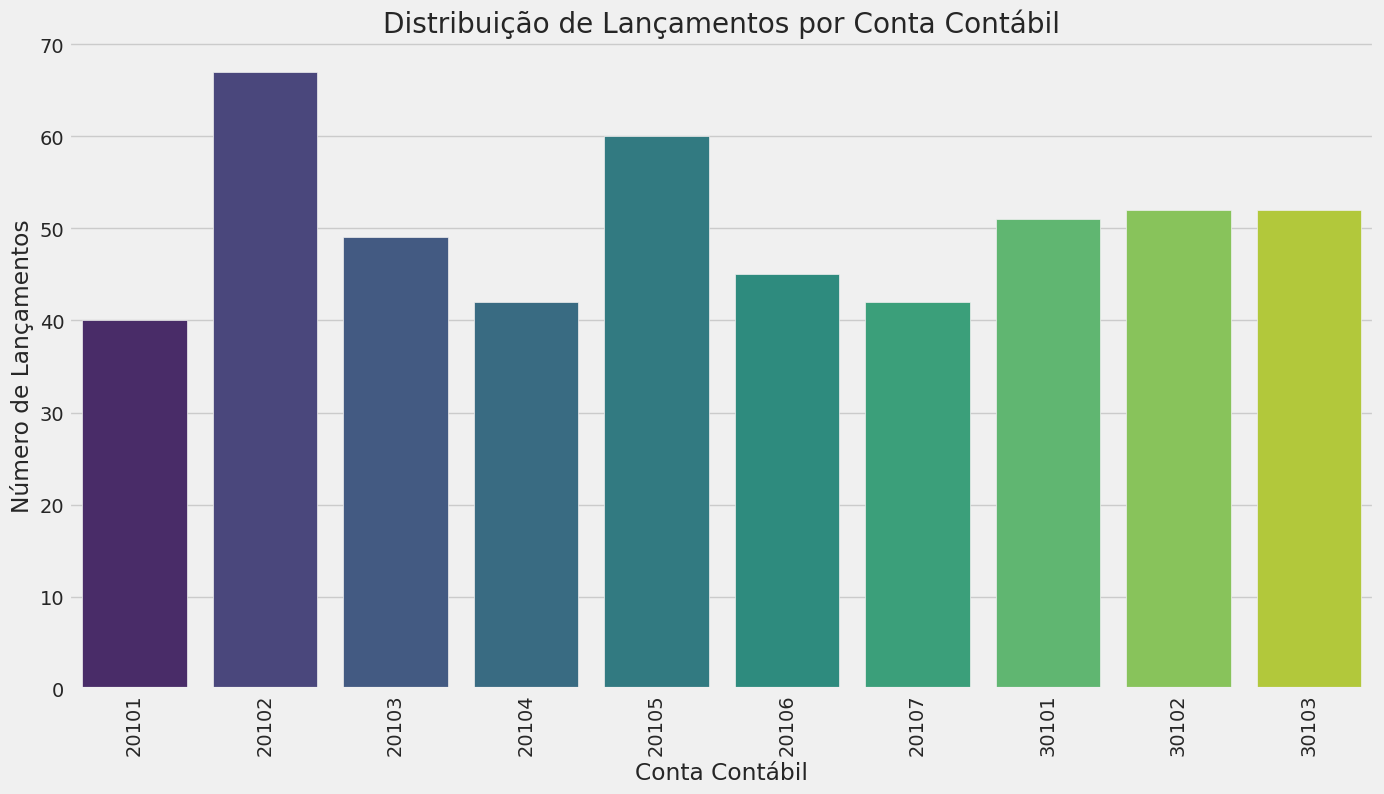

In [4]:
# Montagem de grafico de barras para visualizar a distribuição das classes
print("Distribuição de lançamentos por conta contábil: ")
count_contas = df['CONTA'].value_counts()
print(count_contas)
print("--------------------------------")
# Plotando o gráfico de barras
plt.figure(figsize=(15, 8))
sns.barplot(x=count_contas.index, y=count_contas.values, palette="viridis")
plt.title("Distribuição de Lançamentos por Conta Contábil")
plt.xlabel("Conta Contábil")
plt.ylabel("Número de Lançamentos")
plt.xticks(rotation=90)
plt.show()


## Como podemos tratar o texto para fazer a classificação?
Para tratar o texto, vamos utilizar o *nltk* para limpar o texto com as *stopwords*.

- **Stopwords**: são as palavras mais comuns e frequentes em um idioma ou contexto, que servem como conexão para formar uma oração ou frase. Elas podem ser removidas do texto para melhorar a qualidade da classificação.

O *dataset* a seguir faz a comparação do histórico original com o histórico limpo.

In [5]:
# Tratamento de texto - descrição
import re
from nltk.corpus import stopwords

# função para limpar o texto
def clean_text(text):
    # transformar em minúsculas
    text = str(text).lower()
    # remover numeros
    text = re.sub(r'\d+', ' ', text)
    # remover pontuação e caracteres especiais
    text = re.sub(r'[^\w\s]', ' ', text)
    # remover espaços extras
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    # remover stopwords
    stopwords_pt = set(stopwords.words('portuguese'))
    # Opcional: adicionar stopwords condizentes ao contexto
    custom_stopwords = {'Lançamento', 'pagto', 'aplicações'}
    # update
    stopwords_pt.update(custom_stopwords)
    # Separar as palavras
    words = text.split()
    # Remover as stopwords
    words_filtered = [word for word in words if word not in stopwords_pt and len(word) > 2]
    # Juntar as palavras novamente
    clean_text = ' '.join(words_filtered)
    return clean_text

print("Limpando os textos das descrições...")
# Aplicando a função de limpeza ao DataFrame
# Criando uma coluna com o texto limpo
df["DESCRIÇÃO_LIMPA"] = df["DESCRIÇÃO DO LANÇAMENTO"].apply(clean_text)
# Comparação
print("Comparação entre texto original e texto limpo:")
df[["DESCRIÇÃO DO LANÇAMENTO", "DESCRIÇÃO_LIMPA"]].head(10)

Limpando os textos das descrições...
Comparação entre texto original e texto limpo:


,DESCRIÇÃO DO LANÇAMENTO,DESCRIÇÃO_LIMPA
0,ALUGUEL - Lançamento teste 5506,aluguel lançamento teste
1,IMPOSTO - Lançamento teste 2679,imposto lançamento teste
2,VENDA - Lançamento teste 7912,venda lançamento teste
3,SALARIO - Lançamento teste 4582,salario lançamento teste
4,IMPOSTO - Lançamento teste 1434,imposto lançamento teste
5,VENDA - Lançamento teste 9928,venda lançamento teste
6,VIAGEM - Lançamento teste 5557,viagem lançamento teste
7,SALARIO - Lançamento teste 3615,salario lançamento teste
8,VIAGEM - Lançamento teste 3547,viagem lançamento teste
9,IMPOSTO - Lançamento teste 6514,imposto lançamento teste


## Quais são as palavras mais frequentes?
O *dataset* a seguir mostra as palavras mais frequentes após o tratamento do histórico.

In [6]:
# Análise de frequência das palavras

count_vectorizer = CountVectorizer()
# matriz de contagem de palavras
arr_count = count_vectorizer.fit_transform(df["DESCRIÇÃO_LIMPA"])
# Somando as ocorrências de cada palavra
sum_words = arr_count.sum(axis=0)
# Criando um dicionário de palavras e suas frequências
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
# Ordenar lista da mais frequente para a menos frequente
words_freq_sorted = sorted(words_freq, key=lambda x: x[1], reverse=True)
# Criando DataFrame
df_words_freq = pd.DataFrame(words_freq_sorted, columns=['Palavra', 'Frequência'])

# Mostrando as palavras mais frequentes
print("Palavras mais frequentes nas descrições limpas:")
df_words_freq.head(50) 

Palavras mais frequentes nas descrições limpas:


,Palavra,Frequência
0,lançamento,500
1,teste,500
2,aluguel,67
3,fornecedor,60
4,venda,52
5,rendimento,52
6,recebimento,51
7,anuncio,49
8,software,45
9,imposto,42


## Criando o modelo
Antes de criar o modelo, é criado um filtro para prepará-lo. A divisão do modelo deve ter estratificação com pelo menos 5 ocorrências por classe. A divisão entre dados é composta por: **70% treino e 30% teste**.
Lembrando que:

##### **X = coluna com histórico**
##### **y = coluna com as contas contábeis**

In [7]:
# Criando filtro para preparar modelo. A divisão do modelo deve ter estratificação com pelo menos 5 ocorrências por classe
count_acc = df['CONTA'].value_counts()
valid_acc = count_acc[count_acc >= 5].index
df_filtered = df[df['CONTA'].isin(valid_acc)]

# Criando primeiro modelo de teste
X = df_filtered["DESCRIÇÃO_LIMPA"]
y = df_filtered["CONTA"]
# Divisão entre dados de treino e teste: 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Definir e criar pipeline
text_clf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])   
# Treinando o pipeline
text_clf_pipeline.fit(X_train, y_train)
print("Modelo treinado com sucesso!")    

Modelo treinado com sucesso!


# Relatorio de classificação
O relatório nos mostrará o resultado da classificação dividido em 4 colunas:

- **Precision**: de toda a classificação, qual a porcentagem de acertos? (Mede a qualidade da previsão)
- **Recall**: de todos os exemplos que realmente eram de *X*, quantos o modelo conseguiu encontrar? (Mede a quantidade de acertos)
- **F1-Score**: uma média entre *Precision* e *Recall*. Ótima métrica para verificar o balanceamento do *dataset*
- **Accuracy**: Acurácia é a porcentagem de acertos em relação ao total de previsões
(Acurácia = Número de acertos / Número total de amostras)

## Matriz de confusão
Para ter uma visão mais detalhada de onde tivemos acertos e erros, usaremos a Matriz de Confusão

- Linhas representam a conta real
- Colunas representam a conta prevista pelo modelo
- Os números na diagonal principal são os acertos
- Qualquer número fora da diagonal representa um erro de classificação

Relatório de Classificação: 
              precision    recall  f1-score   support

       20101       1.00      1.00      1.00        12
       20102       1.00      1.00      1.00        20
       20103       1.00      1.00      1.00        15
       20104       1.00      1.00      1.00        13
       20105       1.00      1.00      1.00        18
       20106       1.00      1.00      1.00        13
       20107       1.00      1.00      1.00        12
       30101       1.00      1.00      1.00        15
       30102       1.00      1.00      1.00        16
       30103       1.00      1.00      1.00        16

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



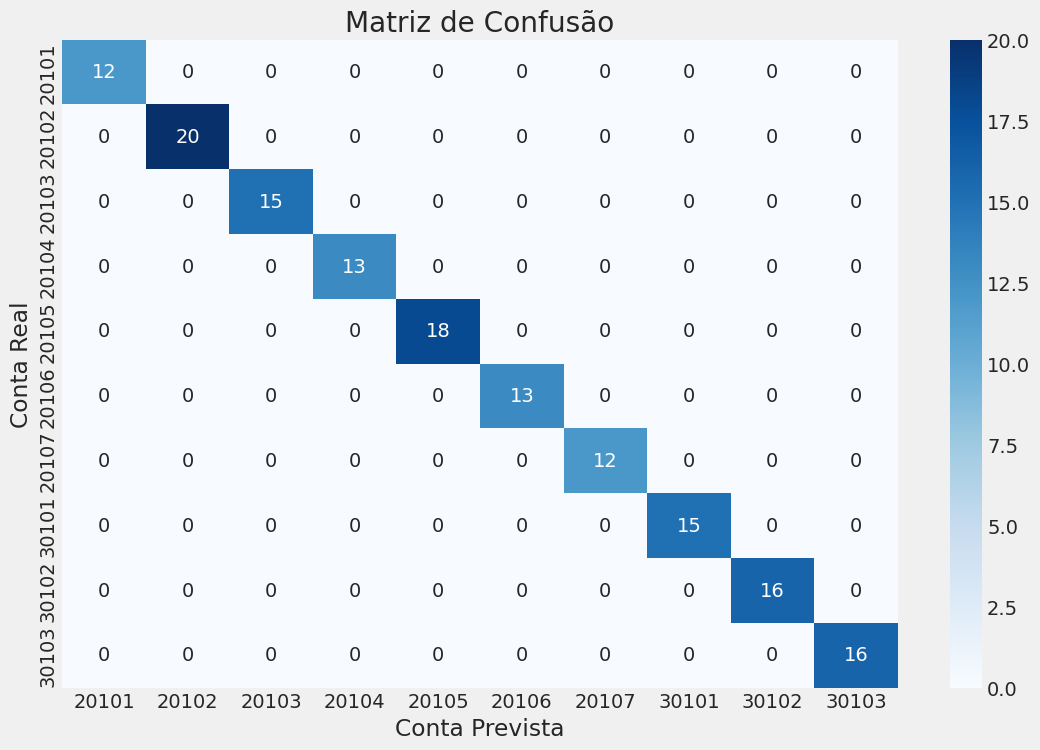

In [8]:
# Avaliando o modelo, criando matriz de confusão e relatório de classificação
# Usando o pipeline para fazer previsões
y_pred = text_clf_pipeline.predict(X_test)
# Imprimindo o relatório de classificação
print("Relatório de Classificação: ")
print(classification_report(y_test, y_pred))
# Gerar e visualizar matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Conta Real')
plt.xlabel('Conta Prevista')
plt.title('Matriz de Confusão')
plt.show()

## Análise de keywords
Aqui será analisado a distribuição das keywords, dividindo seus resultados em 3 colunas:

- Keyword: são as palavras consideradas como principais na classificação do lançamento
- Frequência total: quantas vezes elas aparecem
- Conta dominante: nas vezes em que aparecem, em quais contas seus lançamentos costumam ser atribuídos
  
Através desses dados, é possível prever quais palavras são mais determinantes e menos ambíguas na hora de realizar a classificação dos lançamentos

In [9]:
# Analisando a distribuição das keywords, verificando se pertencem a mais de uma conta
from tqdm.auto import tqdm # barra de progresso
print("Iniciando análise de palavras-chave...")
df_analysis = df_filtered.copy()
# Extraindo todo o vocabulário
vectorizer_vocab = CountVectorizer(min_df=2)
vectorizer_vocab.fit(df_analysis["DESCRIÇÃO_LIMPA"])
vocab = vectorizer_vocab.get_feature_names_out()
print(f"Vocabulário extraído com {len(vocab)} palavras.")

# Iterar sobre cada palavra e calcular as estatísticas
analysis_list = []
for word in tqdm(vocab, desc="Analisando palavras"):
    # Filtrar linhas que contêm a palavra
    df_word = df_analysis[df_analysis["DESCRIÇÃO_LIMPA"].str.contains(rf'\b{word}\b', regex=True)]
    if not df_word.empty:
        total_freq = len(df_word)
        dist = df_word['CONTA'].value_counts()
        dominant_acc = dist.index[0]
        dominant_freq = dist.iloc[0]
        exclusivity = (dominant_freq / total_freq) * 100
        
        # Guarda os resultados
        analysis_list.append({
            "Keyword": word,
            "Frequência Total": total_freq,
            "Conta dominante": dominant_acc,
            "Frequência na conta dominante": dominant_freq,
            "Exclusividade (%)": exclusivity
        })
# Criando DataFrame com os resultados
df_keyword_analysis = pd.DataFrame(analysis_list)
# Ordenando por exclusividade
df_keyword_analysis_sorted = df_keyword_analysis.sort_values(by="Exclusividade (%)", ascending=True)

# Mostrando as palavras com maior exclusividade
print("Palavras com maior exclusividade:")
print(df_keyword_analysis_sorted.head(50))
print("--------------------------------")
# Menos exclusivas
print("Palavras com menor exclusividade:")
print(df_keyword_analysis_sorted[df_keyword_analysis_sorted["Frequência Total"] > 10].sort_values(by="Exclusividade (%)", ascending=False).head(30))

Iniciando análise de palavras-chave...
Vocabulário extraído com 12 palavras.


Analisando palavras:   0%|          | 0/12 [00:00<?, ?it/s]

Palavras com maior exclusividade:
        Keyword  Frequência Total  Conta dominante  \
4    lançamento               500            20102   
9         teste               500            20102   
0       aluguel                67            20102   
1       anuncio                49            20103   
2    fornecedor                60            20105   
3       imposto                42            20104   
5   recebimento                51            30101   
6    rendimento                52            30103   
7       salario                40            20101   
8      software                45            20106   
10        venda                52            30102   
11       viagem                42            20107   

    Frequência na conta dominante  Exclusividade (%)  
4                              67               13.4  
9                              67               13.4  
0                              67              100.0  
1                              49          

## Probabilidade de previsão
Aqui será mostrado a probabilidade de previsão pela ordem das classes do modelo.

In [10]:
# Probabilidade de previsão e coluna de classificação
print("Calculando probabilidades de previsão")
# Obter a matriz de probabilidades
arr_proba = text_clf_pipeline.predict_proba(X)
# Ordem da classe conforme o modelo
model_classes = text_clf_pipeline.classes_
print(f"Ordem das classes conforme o modelo: {model_classes}")
# Criação do map para encontrar o índice da classe
class_index_map = {cls: i for i, cls in enumerate(model_classes)}
# Para cada linha do dataset, descobrir qual o indice da classe
# Pegando dados de y, que são as contas reais de cada lançamento
index_real_cls = y.map(class_index_map).values
# Calculando a probabilidade da classe real para cada linha
real_proba = arr_proba[np.arange(len(y)), index_real_cls]
# Criando coluna no DataFrame
df_filtered.loc[:, 'CLASSIFICAÇÃO_PROB'] = real_proba * 100

# Mostrando o resultado final
print("\nResultado final...")
df_display = df_filtered.copy()
df_display['CLASSIFICAÇÃO_PROB'] = df_display['CLASSIFICAÇÃO_PROB'].map('{:.2f}%'.format)

# Exibir colunas mais importantes
columns_to_display = ['DESCRIÇÃO DO LANÇAMENTO', 'DESCRIÇÃO_LIMPA', 'CLASSIFICAÇÃO_PROB']
print(df_display[columns_to_display].head(20))

Calculando probabilidades de previsão
Ordem das classes conforme o modelo: [20101 20102 20103 20104 20105 20106 20107 30101 30102 30103]

Resultado final...
               DESCRIÇÃO DO LANÇAMENTO              DESCRIÇÃO_LIMPA  \
0      ALUGUEL - Lançamento teste 5506     aluguel lançamento teste   
1      IMPOSTO - Lançamento teste 2679     imposto lançamento teste   
2        VENDA - Lançamento teste 7912       venda lançamento teste   
3      SALARIO - Lançamento teste 4582     salario lançamento teste   
4      IMPOSTO - Lançamento teste 1434     imposto lançamento teste   
5        VENDA - Lançamento teste 9928       venda lançamento teste   
6       VIAGEM - Lançamento teste 5557      viagem lançamento teste   
7      SALARIO - Lançamento teste 3615     salario lançamento teste   
8       VIAGEM - Lançamento teste 3547      viagem lançamento teste   
9      IMPOSTO - Lançamento teste 6514     imposto lançamento teste   
10     ALUGUEL - Lançamento teste 2584     aluguel lançamento 

## Testando inserção de dados
Testada uma nova entrada e retornando a probabilidade de previsão. Nota-se que a probabilidade de previsão vai diminuindo conforme o modelo aprende mais das contas.

In [19]:
# Testando com novo lançamento
new_entries = ["pagto aluguel"]
# Limpando os novos lançamentos
new_entries_clean = clean_text(new_entries)
# Fazendo previsões
proba = text_clf_pipeline.predict_proba([new_entries_clean])
# Obtendo classes previstas
classes = text_clf_pipeline.classes_
# DataFrame mostrando resultados. O .T deixa as contas como linhas
df_results = pd.DataFrame(proba, columns=classes).T
df_results.rename(columns={0: 'Probabilidade'}, inplace=True)
# Convertendo para porcentagem
df_results['Probabilidade'] = df_results['Probabilidade'] * 100
# Ordenando da maior para a menor probabilidade
df_results_sorted = df_results.sort_values(by='Probabilidade', ascending=False)
df_results_sorted['Probabilidade'] = df_results_sorted['Probabilidade'].map('{:.2f}%'.format) 
print("Resultados das previsões para novos lançamentos:")
print(df_results_sorted)

# Mostrando a melhor e pior previsão do modelo
print("Analisando a melhor previsão do modelo...")
# Encontrando a melhor previsão
best_acc = df_results_sorted.iloc[0]
best_proba = df_results_sorted.iloc[0,0]
print(f"Melhor previsão: Conta {best_acc.name} com probabilidade de {best_proba}")

Resultados das previsões para novos lançamentos:
      Probabilidade
20102        76.06%
20105         2.71%
30103         2.68%
30102         2.68%
30101         2.68%
20103         2.67%
20106         2.65%
20107         2.63%
20104         2.63%
20101         2.62%
Analisando a melhor previsão do modelo...
Melhor previsão: Conta 20102 com probabilidade de 76.06%


In [12]:
# Salvando modelo treinado
import joblib
model_name = 'modelo_contabil_pipeline.joblib'
joblib.dump(text_clf_pipeline, model_name)
print(f"Modelo salvo em {model_name}")

Modelo salvo em modelo_contabil_pipeline.joblib


## Testando o modelo já salvo
Repetindo os testes anteriores, mas agora usando o modelo salvo.

In [20]:
# Testando modelo salvo
load_model = joblib.load(model_name)
test_entry = ["TESTE. pagto aluguel"]
# Usando modelo carregado para fazer previsão
predict = load_model.predict(test_entry)
proba = load_model.predict_proba(test_entry)
# Pega a probabilidade da classe prevista
max_prob = proba.max()

print("\nTestando modelo salvo...")
print(f"O lançamento '{test_entry[0]}' foi classificado na conta '{predict[0]}' com probabilidade de {max_prob*100:.2f}%")


Testando modelo salvo...
O lançamento 'TESTE. pagto aluguel' foi classificado na conta '20102' com probabilidade de 81.22%


# Testando o modelo para preencher as contas de lançamentos sem classificação

In [21]:
# Testando modelo para preencher as contas de lançamentos sem classificação
blank_sheet = 'lanc_cont_ml_blank.xlsx'
df = pd.read_excel(blank_sheet)
df.head(5)

# Definindo as colunas e separando os dataframes 
col_his = 'DESCRIÇÃO DO LANÇAMENTO'
col_acc = 'CONTA'  # Coluna onde a conta será preenchida

# Condição para separar treino e classificação
condition_for_class = df[col_acc].isna() | (df[col_acc].astype(str).str.strip() == '')
# DataFrame para classificar
df_for_class = df[condition_for_class].copy()
# DF para treino usando o inverso da condição (~)
df_training = df[~condition_for_class].copy() 
# Verificando os resultados obtidos
print("\n--- Separação de dados concluída ---")
print(f"Total de lançamentos carregados: {len(df)}")
print(f"Lançamentos para TREINO: {len(df_training)}")
print(f"Lançamentos para CLASSIFICAÇÃO: {len(df_for_class)}")

if len(df) == (len(df_training) + len(df_for_class)):
    print("A soma dos lançamentos para treino e classificação confere com o total carregado.")
else:
    print("Atenção: A soma dos lançamentos para treino e classificação NÃO confere com o total carregado.")


--- Separação de dados concluída ---
Total de lançamentos carregados: 514
Lançamentos para TREINO: 500
Lançamentos para CLASSIFICAÇÃO: 14
A soma dos lançamentos para treino e classificação confere com o total carregado.


In [22]:
# treinando modelo com regressão
# filtrando df
acc_count = df_training[col_acc].value_counts()
cutoff = 7
valid_acc = acc_count[acc_count >= cutoff].index
df_filtered = df_training[df_training[col_acc].isin(valid_acc)].copy()

df_filtered[col_acc] = df_filtered[col_acc].astype(int) 
df_filtered["DESCRIÇÃO_LIMPA"] = df_filtered[col_his].apply(clean_text)
X = df_filtered["DESCRIÇÃO_LIMPA"]
y = df_filtered[col_acc]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Dados de treino divididos: {len(X_train)} para treino e {len(X_test)} para teste")

from sklearn.linear_model import LogisticRegression
# Definir e criar pipeline
text_clf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', LogisticRegression(random_state=42)),
    ])
print("Treinando o modelo...")
text_clf_pipeline.fit(X_train, y_train)
print("Modelo treinado com sucesso!")

Dados de treino divididos: 350 para treino e 150 para teste
Treinando o modelo...
Modelo treinado com sucesso!


Relatório de Classificação: 
              precision    recall  f1-score   support

       20101       1.00      1.00      1.00        12
       20102       1.00      1.00      1.00        20
       20103       1.00      1.00      1.00        15
       20104       1.00      1.00      1.00        13
       20105       1.00      1.00      1.00        18
       20106       1.00      1.00      1.00        13
       20107       1.00      1.00      1.00        12
       30101       1.00      1.00      1.00        15
       30102       1.00      1.00      1.00        16
       30103       1.00      1.00      1.00        16

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Matriz de Confusão:


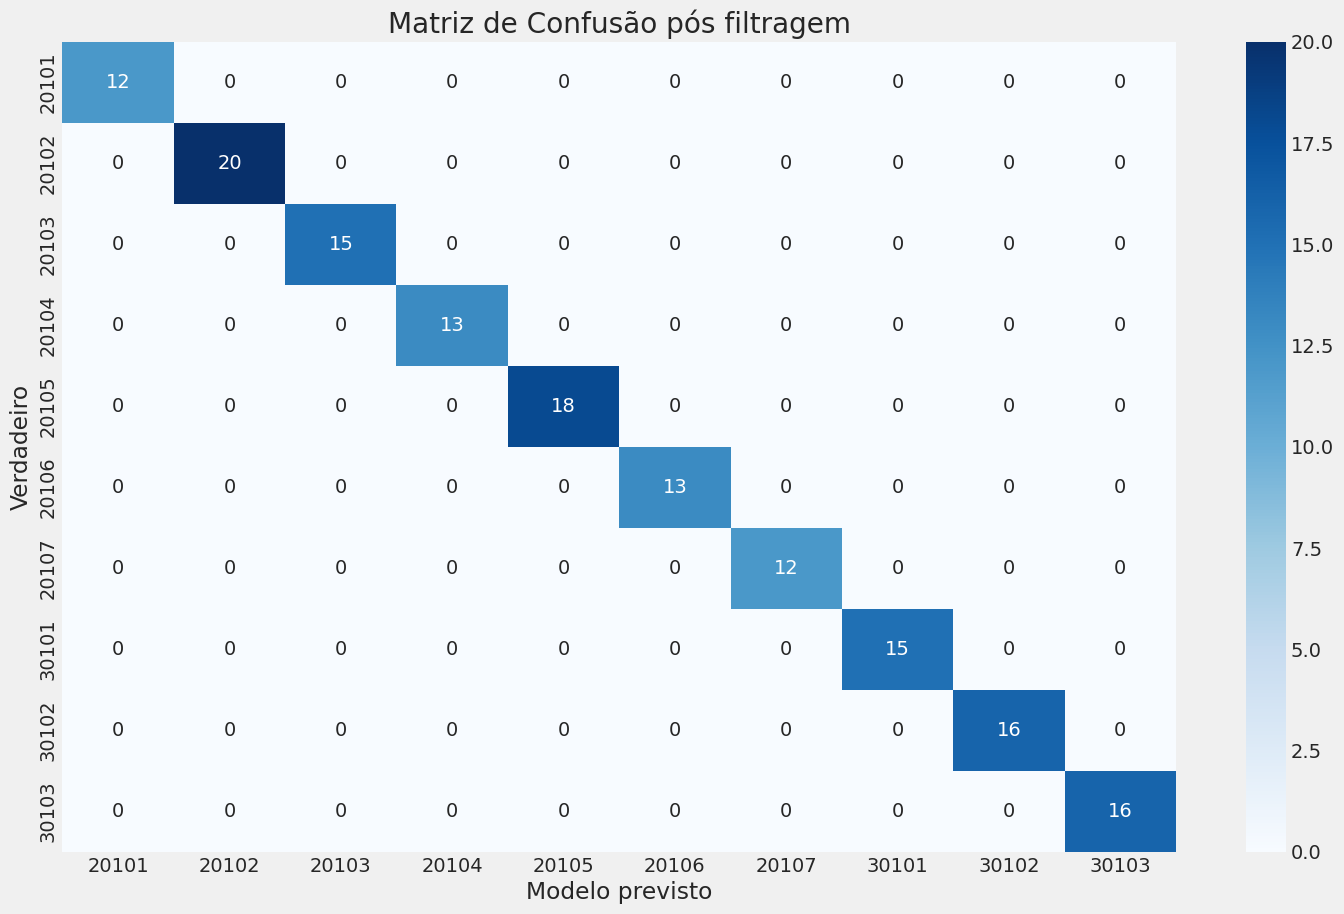

In [23]:
# Avaliando novo modelo
# Avaliando o modelo, criando matriz de confusão e relatório de classificação
# Usando o pipeline para fazer previsões
y_pred = text_clf_pipeline.predict(X_test)
# Imprimindo o relatório de classificação
print("Relatório de Classificação: ")
print(classification_report(y_test, y_pred))
# Gerar e visualizar matriz de confusão
print("Matriz de Confusão:")
conf_matrix = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())
plt.figure(figsize=(16, 10))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.ylabel("Verdadeiro")
plt.xlabel("Modelo previsto")
plt.title("Matriz de Confusão pós filtragem")
plt.show()

In [24]:
# Aplicando regra de negócio para preencher as contas
# Iniciando o processo de classificação
print("Iniciando o processo de classificação...")
classify_texts = df_for_class[col_his].apply(clean_text)
# usando o modelo para fazer as probabilidades
arr_proba = text_clf_pipeline.predict_proba(classify_texts)
# Processar os resultados e aplicar a regra de negócio
fill_accounts = []
final_proba = []
confidence_limit = 0.70 # critério de 70%

for i in range(len(arr_proba)):
    # pega as probabilidades para o lançamento atual
    lanc_proba = arr_proba[i]
    # encontra o indice da maior probabilidade
    best_acc_index = lanc_proba.argmax()
    # valor da maior probabilidade
    max_proba = lanc_proba[best_acc_index]
    # pega o código da conta
    predicted_acc = text_clf_pipeline.classes_[best_acc_index]
    # aplica a regra de negócio
    if max_proba >= confidence_limit:
        fill_accounts.append(predicted_acc)
        final_proba.append(f"{max_proba:.2%}")  # convertendo para porcentagem
    else:
        fill_accounts.append(predicted_acc) # não preencher
        final_proba.append(f"Revisar! Sugestão de conta: {predicted_acc} ({max_proba:.2%})") # convertendo para porcentagem

# Adicionando os resultados ao DataFrame original
df_for_class['CONTA'] = fill_accounts
df_for_class['CLASSIFICAÇÃO_PROB'] = final_proba

print("\nClassificação concluída. Resultados:")
print(df_for_class[[col_his, 'CONTA', 'CLASSIFICAÇÃO_PROB']].head(20))

Iniciando o processo de classificação...

Classificação concluída. Resultados:
                 DESCRIÇÃO DO LANÇAMENTO  CONTA CLASSIFICAÇÃO_PROB
500      IMPOSTO - Lançamento teste 3253  20104             85.82%
501      ANUNCIO - Lançamento teste 2657  20103             87.52%
502        VENDA - Lançamento teste 9626  30102             88.07%
503      SALARIO - Lançamento teste 3147  20101             85.43%
504   RENDIMENTO - Lançamento teste 3658  30103             88.07%
505      ANUNCIO - Lançamento teste 3712  20103             87.52%
506  RECEBIMENTO - Lançamento teste 6968  30101             88.07%
507      IMPOSTO - Lançamento teste 5668  20104             85.82%
508  RECEBIMENTO - Lançamento teste 4918  30101             88.07%
509   FORNECEDOR - Lançamento teste 8684  20105             89.45%
510      IMPOSTO - Lançamento teste 8218  20104             85.82%
511  RECEBIMENTO - Lançamento teste 7256  30101             88.07%
512        VENDA - Lançamento teste 3655  30102   

In [25]:
# Gerando planilha final com os resultados
# Preenchendo os espaços vazios com "Conta já existente"
df_training["CLASSIFICAÇÃO_PROB"] = "Conta já existente"
df_final = pd.concat([df_training, df_for_class], ignore_index=True)
output_file = 'classificacao_contas_resultado.xlsx'
df_final.to_excel(output_file, index=False)
print(f"\nPlanilha final salva como '{output_file}' com {len(df_final)} lançamentos.")
df_final.tail(len(df_for_class)+5)


Planilha final salva como 'classificacao_contas_resultado.xlsx' com 514 lançamentos.


,CONTA,BANCO,DATA,DESCRIÇÃO DO LANÇAMENTO,VALOR,CLASSIFICAÇÃO_PROB
495,20105.0,ITAÚ,25/12/2024,FORNECEDOR - Lançamento teste 8684,"-19,313,65",Conta já existente
496,20104.0,ITAÚ,29/12/2024,IMPOSTO - Lançamento teste 8218,"-7,388,43",Conta já existente
497,30101.0,ITAÚ,30/12/2024,RECEBIMENTO - Lançamento teste 7256,"23,094,68",Conta já existente
498,30102.0,ITAÚ,30/12/2024,VENDA - Lançamento teste 3655,"15,847,42",Conta já existente
499,20104.0,ITAÚ,31/12/2024,IMPOSTO - Lançamento teste 3267,"-16,035,12",Conta já existente
500,20104.0,ITAÚ,20/12/2024,IMPOSTO - Lançamento teste 3253,"-4,569,53",85.82%
501,20103.0,ITAÚ,20/12/2024,ANUNCIO - Lançamento teste 2657,"-1,589,44",87.52%
502,30102.0,ITAÚ,22/12/2024,VENDA - Lançamento teste 9626,"23,137,70",88.07%
503,20101.0,ITAÚ,24/12/2024,SALARIO - Lançamento teste 3147,"-13,255,49",85.43%
504,30103.0,ITAÚ,24/12/2024,RENDIMENTO - Lançamento teste 3658,"11,332,76",88.07%
